# 1. Dataset
The dataset we will be using is [IMDB movies review dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) which contains 50,000 reviews on movies with the labels: positive, negative

In [1]:
import os
import pandas as pd

## 1.1 Kaggle
We will use kaggle to download the dataset.

NOTE: You will need a kaggle.json file, if you do not have it go to your Kaggle profile > account > apis and click "expire api token" and then "create new api token" this should download the kaggle.json file

In [2]:
from google.colab.files import upload

In [3]:
print("Installing kaggle")
!pip install kaggle -q
print("Upload kaggle.json")
upload()
print("Setting kaggle up...")
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!rm -fr sample_data
print("Done!")

Installing kaggle
Upload kaggle.json


Saving kaggle.json to kaggle.json
Setting kaggle up...
Done!


## 1.2 Downloading dataset


In [4]:
DATA_FILENAME = "data.csv"

In [8]:
if not os.path.exists(DATA_FILENAME):
  !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
  print("\nUnzipping dataset...")
  !unzip -q imdb-dataset-of-50k-movie-reviews.zip
  os.rename("IMDB Dataset.csv", DATA_FILENAME)
  os.remove("imdb-dataset-of-50k-movie-reviews.zip")
  print("Dataset is ready to be cleaned!")

 86% 22.0M/25.7M [00:01<00:00, 33.3MB/s]
100% 25.7M/25.7M [00:01<00:00, 22.5MB/s]

Unzipping dataset...
Dataset is ready to be cleaned!


## 1.3 Get inputs and labels
We will use pandas to read the csv file and store the two columns in thier seperate variables

In [9]:
df = pd.read_csv(DATA_FILENAME)
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
X = df["review"].values
y = df["sentiment"].values

## 1.4 Splitting into train and test data

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [12]:
print(
f"""
Shape of X_train, y_train: {X_train.shape}, {y_train.shape}
Shape of X_test, y_test: {X_test.shape}, {y_test.shape}
"""
)


Shape of X_train, y_train: (37500,), (37500,)
Shape of X_test, y_test: (12500,), (12500,)



## 1.5 Remove punctuation

In [13]:
from string import punctuation

In [14]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
X_train[3]

"Average viewers looking for any sense of internal coherence in a film should probably give this one a pass. It generates the same feeling as staring at a curious array of individual images that seem to have some relationship one to another, but never coalesce into a totality.<br /><br />While this isolative approach to creating a kind of cinematic montage may appeal to a few students or critics steeped in the inside language of contemporary filmmaking, it is flatly irritating and condescending to us commoners who just fell off the haywagon. An overt avoidance of accessibility may be the intentional hallmark of auteurs like Kar-wai Wong and Tarantino, but to me it comes across as Andy Warhol warmed over. The only redeeming characteristic I find is in the production values, and them there just ain't going to cut it all by themselfs.<br /><br />This is one of those productions in which you watch and listen and wait anxiously and in vain for some clever development of an idea or thought t

In [16]:
for i, review in enumerate(X_train):
  X_train[i] = "".join([c for c in review if c not in punctuation])

In [17]:
X_train[3]

'Average viewers looking for any sense of internal coherence in a film should probably give this one a pass It generates the same feeling as staring at a curious array of individual images that seem to have some relationship one to another but never coalesce into a totalitybr br While this isolative approach to creating a kind of cinematic montage may appeal to a few students or critics steeped in the inside language of contemporary filmmaking it is flatly irritating and condescending to us commoners who just fell off the haywagon An overt avoidance of accessibility may be the intentional hallmark of auteurs like Karwai Wong and Tarantino but to me it comes across as Andy Warhol warmed over The only redeeming characteristic I find is in the production values and them there just aint going to cut it all by themselfsbr br This is one of those productions in which you watch and listen and wait anxiously and in vain for some clever development of an idea or thought to sustain all the remar

## 1.6 Tokenize
Here is how we will tokenize:

* Remove common words i.e. is, are, am
* Get 1000 most common words in our reviews
* Assign all those 1000 words a numerical value based on popularity
* Create a new list in which the items are the reviews from X_train but the * * review is made from the 1000 most common words.

In [18]:
import re
from nltk.corpus import stopwords
import nltk
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [19]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
class Tokenizer():
  def _preprocess_word(self, word):
    # Remove any characters which are not letters
    word = re.sub(r'[^a-zA-Z]+', '', word)
    return word
  
  def _get_non_common_words(self, array):
    word_list = []

    common_words = set(stopwords.words("english"))
    print("Getting and preprocessing words...")
    for string in tqdm(array):
      for word in string.lower().split():
        word = self._preprocess_word(word)
        if word not in common_words and word != "":
          word_list.append(word)
    
    return word_list
  
  def tokenize(self, X_train, X_test, y_train, y_test, amount_common_words=1000):
    word_list = self._get_non_common_words(X_train)
    corpus = Counter(word_list) # Get common words
    corpus = sorted(corpus, key=corpus.get, reverse=True)[:amount_common_words] # Sort them based on commonnesss and get x (1000) amount of them
    corpus_num_dict = {w: i+1 for i, w in enumerate(corpus)} # Give numerical value to those common words

    X_train_tok, X_test_tok = [], []

    print(f"\nSetting words in arrays...")
    for review in tqdm(X_train):
      # appends the numerical value of every word in review only if it is in the 1000 most common words (corpus_num_dict)
      X_train_tok.append([corpus_num_dict[self._preprocess_word(word)] for word in review.lower().split() 
                                if self._preprocess_word(word) in corpus_num_dict.keys()])

    for review in X_test:
      X_test_tok.append([corpus_num_dict[self._preprocess_word(word)] for word in review.lower().split() 
                                if self._preprocess_word(word) in corpus_num_dict.keys()])
    
    y_train_encodded = [1 if label == "positive" else 0 for label in y_train]
    y_test_encodded = [1 if label == "positive" else 0 for label in y_test]

    print("Tokenized!")

    return np.array(X_train_tok), np.array(y_train_encodded), np.array(X_test_tok), np.array(y_test_encodded), corpus_num_dict

In [21]:
tokenizer = Tokenizer()

In [22]:
X_train, y_train, X_test, y_test, vocab = tokenizer.tokenize(X_train, X_test, y_train, y_test)

Getting and preprocessing words...


  0%|          | 0/37500 [00:00<?, ?it/s]


Setting words in arrays...


  0%|          | 0/37500 [00:00<?, ?it/s]

Tokenized!


<ipython-input-20-23349bc22e77>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X_train_tok), np.array(y_train_encodded), np.array(X_test_tok), np.array(y_test_encodded), corpus_num_dict


In [23]:
len(vocab)

1000

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37500,), (12500,), (37500,), (12500,))

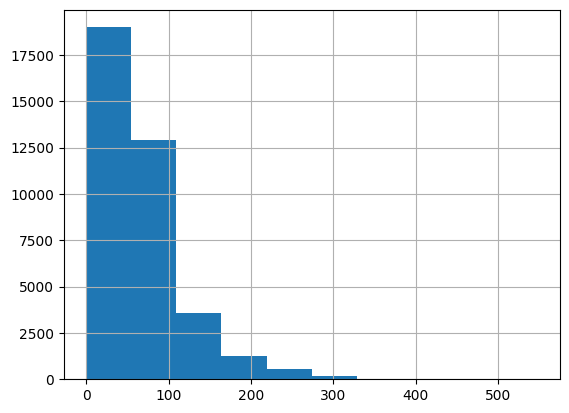

count    37500.000000
mean        68.862907
std         47.800179
min          0.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        547.000000
dtype: float64

In [25]:
rev_len = [len(i) for i in X_train]
pd.Series(rev_len).hist()
plt.show()
print("")
pd.Series(rev_len).describe()

## 1.7 Load dataset

In [26]:
from torch.utils.data import DataLoader, TensorDataset
import torch

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [28]:
BATCH_SIZE = 50

In [29]:
def padding(reviews, length):
    features = np.zeros((len(reviews), length),dtype=int)
    for ii, review in enumerate(reviews):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:length]
    return features

In [30]:
X_train_pad = padding(X_train, 500)
X_test_pad = padding(X_test, 500)

In [31]:
train_ds = TensorDataset(torch.from_numpy(X_train_pad), torch.from_numpy(y_train))
test_ds = TensorDataset(torch.from_numpy(X_test_pad), torch.from_numpy(y_test))

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

len(train_ds), len(train_dl)

(37500, 750)

In [32]:
dataiter = iter(train_dl)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,  14, 511,   1],
        [  0,   0,   0,  ..., 229,  32,  22],
        [  0,   0,   0,  ..., 913,  18, 532],
        ...,
        [  0,   0,   0,  ...,   7,  29, 388],
        [  0,   0,   0,  ...,  21,  29, 499],
        [  0,   0,   0,  ...,  98, 602, 877]])
Sample input: 
 tensor([1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 0])
